# Mineral Prospectivity Mapping

### Ehsan Farahbakhsh

*EarthByte Group, School of Geosciences, University of Sydney, NSW 2006, Australia*

This notebook enables the user to create the prospectivity map of target mineralization. It comprises two main sections; in the first section, the available datasets are visualized, and in the second section, a variety of machine learning methods are applied to create a prospectivity map.

### Libraries

In [4]:
# !conda install -c conda-forge contextily --verbose
# !conda install contextily
# !conda install -c conda-forge ipywidgets -v
# !pip install pulearn -v
# !conda install -c conda-forge rioxarray -v
# !conda install -c conda-forge skimage -v
# !conda install -c conda-forge scikit-image -v
# !conda install -c conda-forge scikit-learn -v
# !conda install -c conda-forge tqdm -v
# !conda install -c conda-forge seaborn -v

^C


In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import namedtuple
import contextily as cx
import csv
import functools
import geopandas as gpd
import glob
from ipywidgets import interact
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
from numpy import genfromtxt

from osgeo import gdal
from osgeo import osr
import os
import pandas as pd
from pprint import pprint
from pulearn import BaggingPuClassifier
import rioxarray as rxr
from scipy import interp
import scipy.spatial
from scipy.spatial import distance_matrix
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import mapping
import shapely.strtree
from skimage import exposure, util
from skimage.feature import graycomatrix, graycoprops
from tqdm.notebook import tqdm

import sklearn
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from multiprocessing import Pool
import multiprocessing as mp

In [2]:
# nsw_boundary = gpd.read_file('./Datasets/Frames/NSW_STATE_POLYGON_shp_GDA94_NoIsland.shp')
# lachlan_boundary = gpd.read_file('./Datasets/Frames/Lachlan_Boundary.shp')

# # comment one of the lines below to map cobalt or nickel occurrences
# #commodity = gpd.read_file('./Datasets/Mineral Occurrences/cobalt.shp')
# # commodity = gpd.read_file('./Datasets/Mineral Occurrences/nickel.shp')
# # commodity = gpd.read_file('./Datasets/Mineral_Occurrences_2/MinOcc.shp')
# commodity = gpd.read_file('./Datasets/Mineral_Occurrences_3/NiCo_lat.shp')

# mineralization_types = commodity.NSW_CLASS.unique()
# mineralization_types = np.array(mineralization_types.astype(str))
# mineralization_types.sort()

# print(commodity.NSW_CLASS.value_counts())

# @interact(mineralization_type=mineralization_types)
# def show_map(mineralization_type):
#     fig, ax = plt.subplots(figsize=(15, 15))
#     data = commodity[commodity.NSW_CLASS==mineralization_type]
#     data.plot(ax=ax, edgecolor='black', color='yellow')
#     nsw_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=2)
#     lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
#     cx.add_basemap(ax, crs='EPSG:7855', source=cx.providers.Esri.WorldGrayCanvas)
#     ax.set_title(mineralization_type)
#     plt.show()

### Target Commodity and Mineralisation Type

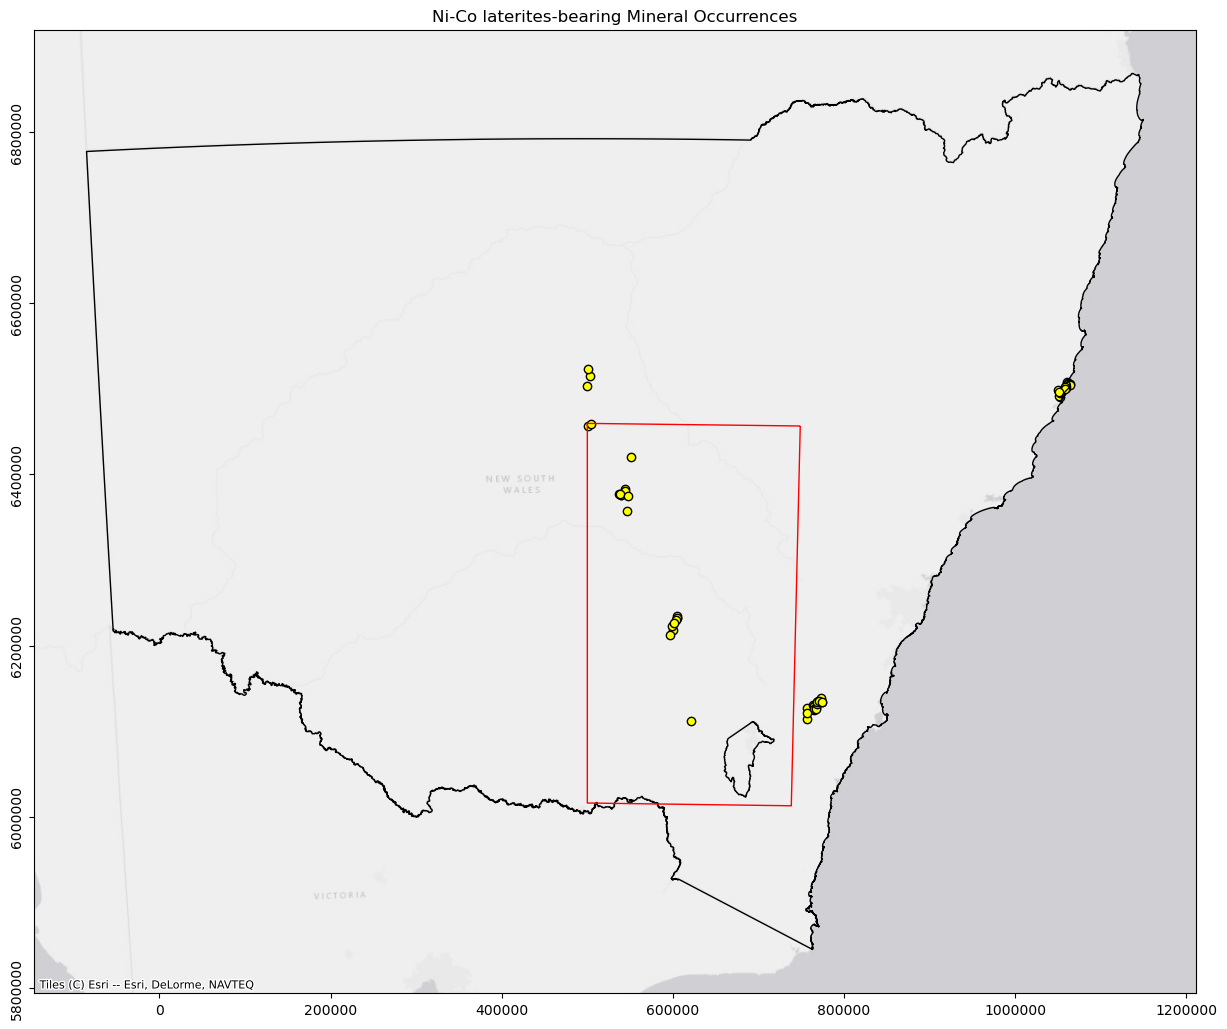

In [2]:
# uncomment the target commodity
commodity = 'Ni-Co laterites'

# uncomment the relevant shapefile
# mines = gpd.read_file('./Datasets/Mineral_Occurrences_2/MinOcc.shp')
mines_u = gpd.read_file('./Datasets/Mineral_Occurrences_3/NiCo_lat.shp')
mines = mines_u.to_crs('epsg:7855')

# read boundaries
nsw_boundary_u = gpd.read_file('./Datasets/Frames/NSW_STATE_POLYGON_shp_GDA94_NoIsland.shp')
nsw_boundary = nsw_boundary_u.to_crs('epsg:7855')
lachlan_boundary_u = gpd.read_file('./Datasets/Frames/Lachlan_Boundary.shp')
lachlan_boundary = lachlan_boundary_u.to_crs('epsg:7855')

# target mineralisation types
nsw_class = ['Ni-Co laterites']

# plot the mineral occurrences
fig, ax = plt.subplots(figsize=(15, 15))
mines.plot(ax=ax, edgecolor='black', color='yellow')
nsw_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
lachlan_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
# Esri: WorldStreetMap, DeLorme, WorldTopoMap, WorldImagery, WorldTerrain, WorldShadedRelief, WorldPhysical, OceanBasemap,
# NatGeoWorldMap, WorldGrayCanvas
cx.add_basemap(ax, crs='EPSG:7855', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.set_title(f'{commodity}-bearing Mineral Occurrences')
plt.show()

In [3]:
# comment one of the lines below to map cobalt or nickel occurrences
#commodity = gpd.read_file('./Datasets/Mineral Occurrences/cobalt.shp')
# commodity = gpd.read_file('./Datasets/Mineral Occurrences/nickel.shp')
commod_u = gpd.read_file('./Datasets/Mineral_Occurrences_2/MinOcc.shp')
commod = commod_u.to_crs('epsg:7855')
# commodity = gpd.read_file('./Datasets/Mineral_Occurrences_3/NiCo_lat.shp')

mineralization_types = commod.NSW_CLASS.unique()
mineralization_types = np.array(mineralization_types.astype(str))
mineralization_types.sort()

print(commod.NSW_CLASS.value_counts())

@interact(mineralization_type=mineralization_types)
def show_map(mineralization_type):
    fig, ax = plt.subplots(figsize=(15, 15))
    data = commod[commod.NSW_CLASS==mineralization_type]
    data.plot(ax=ax, edgecolor='black', color='yellow')
    nsw_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=2)
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7855', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title(mineralization_type)
    plt.show()

Construction materials                                       9883
Structurally controlled low sulfide Au                       3962
Unclassified                                                 3425
Structurally controlled high sulfide base metal (+/- Au)     1796
Au-Ag eluvial/alluvial/deep lead                             1473
                                                             ... 
Mafic setting-hosted Cu-Zn-(Au-Ag)                              1
Nb-Y-F pegmatite                                                1
Ultramafic-related deposits - Picrite-related Ni-Cu-(PGE)       1
Au-(Bi) skarn                                                   1
Sandstone-hosted U                                              1
Name: NSW_CLASS, Length: 74, dtype: int64


interactive(children=(Dropdown(description='mineralization_type', options=('Amagmatic banded iron formation', …

### Raster datasets
#### Magnetic field intensity

In [5]:
magnetic_filenames = [
    f'./Datasets/Magnetics/Magmap2019_tmr_rtp_enh_Bzz_PGravTHD.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC42km50kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC36km42kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC24km30kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC16km20kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC12km16kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC8km12kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC4km8kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC2km4kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC1km2kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC0m500mRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_enh_PGrav.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_PSusp.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_Phase.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_as_.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_05vd.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_1vd.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_cellsize40m.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_1vd.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi.tif'
    ]

@interact(dataset=magnetic_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7855', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Total magnetic intensity (nT)', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Magnetics/Magmap2019_tmr_rtp_enh_Bz…

#### Gravity

In [6]:
gravity_filenames = [
    f'./Datasets/Gravity/Gravmap2019_freeair_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_freeair.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_tilt_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_tilt.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_05vd_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_05vd.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_1vd_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_1vd.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_tilt_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_tilt.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_05vd_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_05vd.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_1vd_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_1vd.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba.tif',
    f'./Datasets/Gravity/Gravmap2016_scba.tif',
    f'./Datasets/Gravity/Gravmap2016_iso_resid_anom.tif',
    f'./Datasets/Gravity/Gravmap2016_cscba.tif'
    ]

@interact(dataset=gravity_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))
    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7855', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Gravity (mGal)', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Gravity/Gravmap2019_freeair_IA.tif'…

#### Radiometrics

In [7]:
radiometric_filenames = [
    f'./Datasets/Radiometrics/Radmap2019_unfilt_u_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_unfilt_th_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_unfilt_k_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_unfil_terrestrial_dose_rate.tif',
    f'./Datasets/Radiometrics/Radmap2019_u2_th_ratio.tif',
    f'./Datasets/Radiometrics/Radmap2019_u_th_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_u_k_ratio.tif',
    f'./Datasets/Radiometrics/Radmap2019_tk_k_ratio.tif',
    f'./Datasets/Radiometrics/Radmap2019_filt_u_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_filt_th_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_filt_terrestrial_dose_rate.tif',
    f'./Datasets/Radiometrics/Radmap2019_filt_k_pct.tif'
    ]

@interact(dataset=radiometric_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7855', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Radiation dose rate', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Radiometrics/Radmap2019_unfilt_u_pc…

#### Remote sensing

In [8]:
rs_filenames = [
    f'./Datasets/Remote_Sensing/Silica_Index.tif',
    f'./Datasets/Remote_Sensing/Quartz_Index.tif',
    f'./Datasets/Remote_Sensing/Opaque_Index.tif',
    f'./Datasets/Remote_Sensing/MgOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/MgOH_Group_Composition.tif',
    f'./Datasets/Remote_Sensing/Kaolin_Group_Index.tif',
    f'./Datasets/Remote_Sensing/Green_Vegetation_Content.tif',
    f'./Datasets/Remote_Sensing/Ferrous_Iron_Index.tif',
    f'./Datasets/Remote_Sensing/Ferrous_Iron_in_MgOH.tif',
    f'./Datasets/Remote_Sensing/Ferric_Oxide_Content.tif',
    f'./Datasets/Remote_Sensing/Ferric_Oxide_Composition.tif',
    f'./Datasets/Remote_Sensing/FeOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/AlOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/AlOH_Group_Composition.tif'
]
    
@interact(dataset=rs_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)
    raster_clipped = np.where(raster_clipped==raster_clipped[0,0], np.nan, raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7855', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Reflectance', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Remote_Sensing/Silica_Index.tif', '…

#### Digital Elevation Model

In [9]:
dem_filenames = [
    #f'./Datasets/Elevation/Gravmap2019_elev_ausdrape_geoid.tif',
    f'./Datasets/Elevation/Gravmap2019_dem_geoid.tif',
    f'./Datasets/Elevation/Gravmap2019_dem_ellipsoid.tif',
    #f'./Datasets/Elevation/Gravmap2019_ausdrape_ellipsoid.tif'
]
    
@interact(dataset=dem_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7855', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Digital Elevation Model', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Elevation/Gravmap2019_dem_geoid.tif…

### Extracting the coordinates of target mineral occurrences

In [10]:
def get_deposits(nsw_class, boundary):
    deposit_x = []
    deposit_y = []
    deposit_num = 0
    
    for c in nsw_class:
        deposits = commod[commod.NSW_CLASS == c]
        deposits_within_boundary = gpd.sjoin(deposits, boundary, how='inner', op='within')
        
        deposit_num += deposits_within_boundary.shape[0]
        
        deposit_x_ = deposits_within_boundary.geometry.x
        deposit_y_ = deposits_within_boundary.geometry.y
    
        deposit_x.extend(pd.Series.tolist(deposit_x_))
        deposit_y.extend(pd.Series.tolist(deposit_y_))
    
    return deposit_num, deposit_x, deposit_y

# export the coordinates to a CSV file
coords_file = f'./{commodity}/training_data_{commodity}_deposit_coords.csv'

if os.path.isfile(coords_file):
    print('The coordinates of deposits already exist.')
    deposit_coords = pd.read_csv(coords_file, index_col=False)
    deposit_num = int(deposit_coords.shape[0])
    deposit_x = pd.Series.tolist(deposit_coords['X'])
    deposit_y = pd.Series.tolist(deposit_coords['Y'])
else:
    deposit_num, deposit_x, deposit_y = get_deposits(nsw_class, lachlan_boundary)
    deposit_coords = pd.DataFrame(deposit_x, columns=['X'])
    deposit_coords['Y'] = deposit_y
    deposit_label = [1] * deposit_num
    deposit_coords['label'] = deposit_label
    deposit_coords.to_csv(coords_file, index=False)
    print(f'The coordinates of deposits have been saved to {coords_file}.')

The coordinates of deposits already exist.


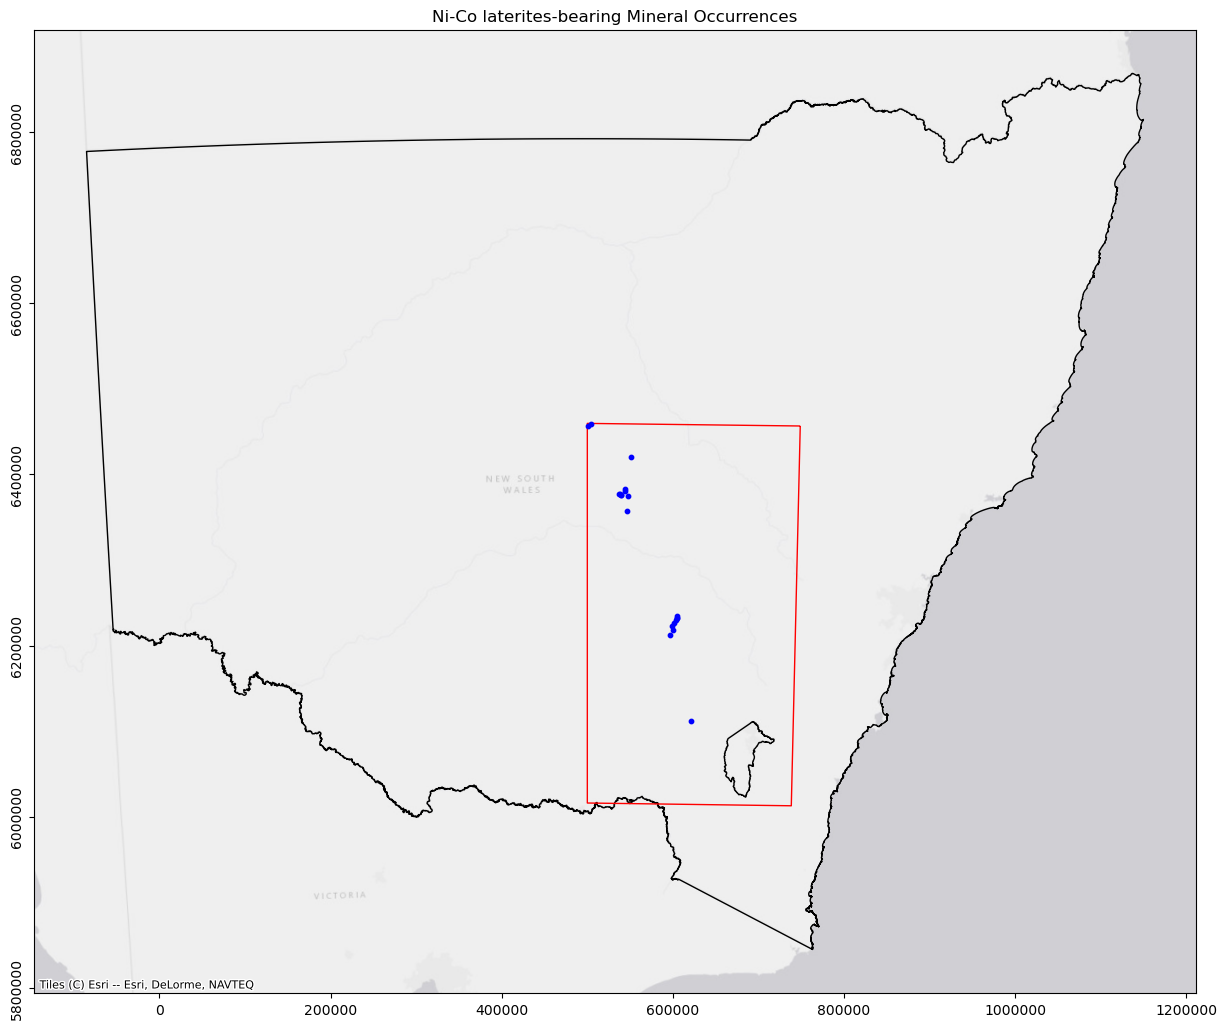

In [11]:
# Read the CSV file with occurrences
occurrences = pd.read_csv(coords_file)

# Create a GeoDataFrame from the CSV data
geometry = gpd.points_from_xy(occurrences['X'], occurrences['Y'])
occurrences_gdf = gpd.GeoDataFrame(occurrences, geometry=geometry)

# Plot the mineral occurrences
fig, ax = plt.subplots(figsize=(15, 15))
nsw_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
lachlan_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
occurrences_gdf.plot(ax=ax, color='blue', marker='o', markersize=10)
cx.add_basemap(ax, crs='EPSG:7855', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.set_title(f'{commodity}-bearing Mineral Occurrences')
plt.show()

### Training data file
The training data file containing features and labels is generated. The rows in this file represent samples and each column represents a feature. A specific function has been defined for each type of features to extract feature values at desired points that involve mineral occurrences, random, and target locations.
#### Faults/dykes and electrical resistivity


Careful with the search radius below, needs to be in metres?

In [12]:
# calculate the distance from a point to linear features like faults and dykes
def get_fault_distance(xs, ys):
#     faults = gpd.read_file('./Datasets/Polylines/MetamorphicBndys/MetamorphicBndys.shp')
#     faults = faults.to_crs('epsg:7855')
#     # construct a spatial tree considering the geometries of all faults/dykes
#     fault_tree = shapely.strtree.STRtree(faults.geometry)
    
    fault_filenames = [
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_WinnamboolFormation.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_WDB.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_THO.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_RenmarkGroup.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_PTB.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_PMIP.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_NEO.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_MurrayBasinQuaternaryCover.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_LoxtonSands.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_LAO.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_GeeraClay.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_GAB.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_EttrickFormation.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_DuddoLimestone.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_DLO.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_CUR.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_CSP.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_CIP.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_CalivilFormation.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_BookpurnongFm.shp',
        './Datasets/Polylines/RockUnitBndyFaults/RockUnitBndyFaults_BlanchetownClay.shp',
        
        './Datasets/Polylines/IntrusionBndys/IntrusionBndys.shp',
        './Datasets/Polylines/MetamorphicBndys/MetamorphicBndys.shp',
        './Datasets/Polylines/MetamorphicIsograds/MetamorphicIsograds.shp'
        ]
    
    fault_trees = []
    for fault_file in fault_filenames:
        faults = gpd.read_file(fault_file)
        faults = faults.to_crs('epsg:7855')
        # construct a spatial tree considering the geometries of all faults/dykes
        fault_trees.append(shapely.strtree.STRtree(faults.geometry))
    
    points = [Point(x, y) for x, y in zip(xs, ys)]
    distance_to_faults = []
    column_names2 = []
#     for p in points:
#         distance_to_faults.append(round(p.distance(fault_trees.geometries[fault_trees.nearest(p)]), 2))
    for idx2, tree2 in enumerate(fault_trees):
        distance_to_faults.append([round(p.distance(tree2.geometries[tree2.nearest(p)]), 2) for p in points])
        column_names2.append(os.path.splitext(os.path.basename(fault_filenames[idx2]))[0]+'_Lines')    
    
    #return pd.DataFrame(np.array(distance_to_faults).T, columns=['Faults'])
    return pd.DataFrame(np.array(distance_to_faults).T, columns=column_names2)

# calculate the distance from a point to contacts
def get_contact_distance(xs, ys):
    polygon_filenames = [
        './Datasets/Polygons/RockUnits/RockUnits_THO.shp',
        './Datasets/Polygons/RockUnits/RockUnits_NEO.shp',
        './Datasets/Polygons/RockUnits/RockUnits_LAO.shp',
        './Datasets/Polygons/RockUnits/RockUnits_DLO.shp',
        './Datasets/Polygons/RockUnits/RockUnits_CUR.shp',
        
        './Datasets/Polygons/Intrusions/Intrusions_Tabberabberan.shp',
        './Datasets/Polygons/Intrusions/Intrusions_KanimblanTablelands.shp',
        './Datasets/Polygons/Intrusions/Intrusions_HunterBowen.shp',
        './Datasets/Polygons/Intrusions/Intrusions_Esk.shp',
        './Datasets/Polygons/Intrusions/Intrusions_Delamerian.shp'
        ]
    
    contact_trees = []
    for polygon_file in polygon_filenames:
        data = gpd.read_file(polygon_file)
        data = data.to_crs('epsg:7855')
        data = data.boundary
        # construct a spatial tree considering the geometries of all contacts
        contact_trees.append(shapely.strtree.STRtree(data.geometry))
    
    points = [Point(x, y) for x, y in zip(xs, ys)]
    distance_to_contacts = []
    column_names = []
    for idx, tree in enumerate(contact_trees):
        distance_to_contacts.append([round(p.distance(tree.geometries[tree.nearest(p)]), 2) for p in points])
        column_names.append(os.path.splitext(os.path.basename(polygon_filenames[idx]))[0]+'_Contact')
    return pd.DataFrame(np.array(distance_to_contacts).T, columns=column_names)

# # preprocess the resistivity data
# resistivity_pc_file = './Datasets/Resistivity/Resistivity_PCs.csv'

# if os.path.isfile(resistivity_pc_file):
#     print('The principal components of resistivity data already exist.')
#     selected_components = pd.read_csv(resistivity_pc_file, index_col=False)
# else:
#     unique_depths = resistivity_raw.Depth_m_.unique()
#     unique_depths = -np.sort(-unique_depths)

#     resistivity_data = []
#     for i in unique_depths:
#         resistivity_data.append(resistivity_raw[resistivity_raw.Depth_m_==i].values)

#     resistivity_data = np.array(resistivity_data)
#     resistivity_features = np.zeros((resistivity_data.shape[1], resistivity_data.shape[0]))
    
#     for i in range(resistivity_data.shape[0]):
#         resistivity_features[:, i] = resistivity_data[i, :, 3]
        
#     scaler = StandardScaler()
#     scaler.fit(resistivity_features)
#     resistivity_features = scaler.transform(resistivity_features)

#     # pca
#     pca = PCA()
#     components = pca.fit_transform(resistivity_features)
#     var_ratio = pca.explained_variance_ratio_
#     var_sum = 0
    
#     for i in range(len(var_ratio)):
#         if var_sum >= 0.99:
#             break
#         else:
#             var_sum += var_ratio[i]

#     selected_components = components[:, :i]
#     resistivity_column_names = [f'Res_C{c}' for c in list(range(1, i+1))]
#     selected_components = pd.DataFrame(selected_components, columns=resistivity_column_names)
#     selected_components.to_csv(resistivity_pc_file, columns=resistivity_column_names, index=False)

#     print(f'The principal components of resistivity data have been saved to {resistivity_pc_file}.')

# # extract the value of the closest point
# def get_resistivity_data(xs, ys):
#     resistivity_raw['X'] = resistivity_raw['geometry'].x
#     resistivity_raw['Y'] = resistivity_raw['geometry'].y

#     unique_depths = resistivity_raw.Depth_m_.unique()
#     unique_depths = -np.sort(-unique_depths)

#     resistivity_data = []
#     for i in unique_depths:
#         resistivity_data.append(resistivity_raw[resistivity_raw.Depth_m_==i].values)

#     resistivity_data = np.array(resistivity_data)
#     resistivity_x = resistivity_data[0, :, 5]
#     resistivity_y = resistivity_data[0, :, 6]
    
#     resistivity_tree = scipy.spatial.cKDTree(np.c_[resistivity_x, resistivity_y])
    
#     # query the tree for target points
#     _, indexes = resistivity_tree.query(np.c_[xs, ys], k=1)
#     resistivity_points = selected_components.to_numpy()[indexes, :]
#     return pd.DataFrame(resistivity_points, columns=selected_components.columns)

# concatenate and export the features generated using the functions above
def get_vector_data(xs, ys):
    fault_distance_df = get_fault_distance(xs, ys)
    contact_distance_df = get_contact_distance(xs, ys)
    
    data = pd.concat([fault_distance_df, contact_distance_df], axis=1).reset_index(drop=True)
    #data = pd.concat([contact_distance_df], axis=1).reset_index(drop=True)
    #data = pd.concat([fault_distance_df], axis=1).reset_index(drop=True)
    return data

vector_file = f'./{commodity}/training_data_{commodity}_deposit_vector.csv'

if os.path.isfile(vector_file):
    print('The vector dataset (deposits) already exists.')
    deposit_vector_data = pd.read_csv(vector_file, index_col=False)
else:
    deposit_vector_data = get_vector_data(deposit_x, deposit_y)
    deposit_vector_data = deposit_vector_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_vector_data.to_csv(vector_file, index=False)
    print(f'The vector dataset (deposits) has been saved to {vector_file}.')

The vector dataset (deposits) already exists.


#### Geological provinces and rock units

In [13]:
# extract the geology code
def get_categorical_data(xs, ys):
    geology_filenames = [
        #'./Datasets/Polygons/RockUnits/RockUnits_LAO_test.shp'  # the mafic-ultramafic rocks
        './Datasets/Polygons/Intrusions/Intrusions_Tabberabberan.shp',
        './Datasets/Polygons/Intrusions/Intrusions_KanimblanTablelands.shp',
        './Datasets/Polygons/Intrusions/Intrusions_HunterBowen.shp',
        './Datasets/Polygons/Intrusions/Intrusions_Esk.shp',
        './Datasets/Polygons/Intrusions/Intrusions_Delamerian.shp',
        
        './Datasets/Polygons/MetamorphicFacies/MetamorphicFacies_Tabberabberan.shp',
        './Datasets/Polygons/MetamorphicFacies/MetamorphicFacies_Olarian.shp',
        './Datasets/Polygons/MetamorphicFacies/MetamorphicFacies_KanimblanTablelands.shp',
        './Datasets/Polygons/MetamorphicFacies/MetamorphicFacies_HunterBowen.shp',
        './Datasets/Polygons/MetamorphicFacies/MetamorphicFacies_Esk.shp',
        './Datasets/Polygons/MetamorphicFacies/MetamorphicFacies_Delamerian.shp',
        './Datasets/Polygons/MetamorphicFacies/MetamorphicFacies_Benambran.shp',
        
        './Datasets/Polygons/RockUnits/RockUnits_WinnamboolFormation.shp',
        './Datasets/Polygons/RockUnits/RockUnits_WDB.shp',
        './Datasets/Polygons/RockUnits/RockUnits_THO.shp',
        './Datasets/Polygons/RockUnits/RockUnits_RenmarkGroup.shp',
        './Datasets/Polygons/RockUnits/RockUnits_PTB.shp',
        './Datasets/Polygons/RockUnits/RockUnits_PMIP.shp',
        './Datasets/Polygons/RockUnits/RockUnits_NEO.shp',
        './Datasets/Polygons/RockUnits/RockUnits_MurrayBasinQuaternaryCover.shp',
        './Datasets/Polygons/RockUnits/RockUnits_LoxtonSands.shp',
        './Datasets/Polygons/RockUnits/RockUnits_LAO.shp',
        './Datasets/Polygons/RockUnits/RockUnits_GeeraClay.shp',
        './Datasets/Polygons/RockUnits/RockUnits_GAB.shp',
        './Datasets/Polygons/RockUnits/RockUnits_EttrickFormation.shp',
        './Datasets/Polygons/RockUnits/RockUnits_DuddoLimestone.shp',
        './Datasets/Polygons/RockUnits/RockUnits_DLO.shp',
        './Datasets/Polygons/RockUnits/RockUnits_CUR.shp',
        './Datasets/Polygons/RockUnits/RockUnits_CSP.shp',
        './Datasets/Polygons/RockUnits/RockUnits_CIP.shp',
        './Datasets/Polygons/RockUnits/RockUnits_CalivilFormation.shp',
        './Datasets/Polygons/RockUnits/RockUnits_BookpurnongFormation.shp',
        './Datasets/Polygons/RockUnits/RockUnits_BlanchetownClay.shp'
        ]
    
    points = [Point(x, y) for x, y in zip(xs, ys)]
    glcode =  pd.DataFrame()
    
    for map_name in tqdm(geology_filenames):
        geology_map = gpd.read_file(map_name)
        geology_map = geology_map.to_crs('epsg:7855')
        temp = []
        for point in points:
            temp_val = 'Null'
#             for index, row in geology_map.iterrows():
#                 if point.within(row.geometry):
#                     temp_val = row.Descriptio
#                     break
#             if 'Dominant_L' in geology_map.columns:
#                 for index, row in geology_map.iterrows():
#                     if point.within(row.geometry):
#                         temp_val = row.Dominant_L
#                         break
            if 'Ultramafic' in geology_map.columns and 'Cycle' in geology_map.columns:
                for index, row in geology_map.iterrows():
                    if point.within(row.geometry):
                        if row.Ultramafic == 'Yes':
                            temp_val = 'ultramafic' + '_' + row.Cycle
                        elif row.Ultramafic == 'No':
                            temp_val = 'non_ult' + '_' + row.Cycle
                        break
#             elif 'Dominant_L' in geology_map.columns:
#                 for index, row in geology_map.iterrows():
#                     if point.within(row.geometry):
#                         temp_val = row.Dominant_L
#                         break
            elif 'MetFacies' in geology_map.columns:
                for index, row in geology_map.iterrows():
                    if point.within(row.geometry):
                        temp_val = row.MetFacies
                        break
#             elif 'Descriptio' in geology_map.columns:
#                 for index, row in geology_map.iterrows():
#                     if point.within(row.geometry):
#                         temp_val = row.Descriptio
#                         break
            temp.append(temp_val)
        column_name = os.path.splitext(os.path.basename(map_name))[0]
        glcode[column_name] =  temp
    return glcode

# export the features generated using the functions above
categorical_file = f'./{commodity}/training_data_{commodity}_deposit_categorical.csv'

if os.path.isfile(categorical_file):
    print('The categorical dataset (deposits) already exists.')
    deposit_categorical_data = pd.read_csv(categorical_file, index_col=False)
else:
    deposit_categorical_data = get_categorical_data(deposit_x, deposit_y)
    deposit_categorical_data = deposit_categorical_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_categorical_data.to_csv(categorical_file, index=False)
    print(f'The categorical dataset (deposits) has been saved to {categorical_file}.')

  0%|          | 0/33 [00:00<?, ?it/s]

The categorical dataset (deposits) has been saved to ./Ni-Co laterites/training_data_Ni-Co laterites_deposit_categorical.csv.


### Grids

In [14]:
# calculate mean and standard deviation in a buffer zone (circle) surrounding each target point
def get_mean_std(xs, ys, raster_np, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    stds = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
            stds.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

            radius_ = math.ceil(radius*raster_np.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius_, radius_+1):
                Y = int((radius_*radius_-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_np.shape[1]-1 and yc >= 0 and yc <= raster_np.shape[0]-1:
                        points_circle.append((xc, yc))
                    
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_np.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_np[yy, xx]))
            stds.append(np.nanstd(raster_np[yy, xx]))
            
    return means, stds

# calculate dissimilarity and correlation in a window (square) surrounding each target point
def get_diss_corr(xs, ys, raster_np, bounds, patch_size):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    dissimilarity = []
    correlation = []
    
    for point in points:
        x = point.x
        y = point.y
        
        left = max(x-patch_size/2, bounds[0])
        right = min(x+patch_size/2, bounds[2])
        top = min(y+patch_size/2, bounds[3])
        bottom = max(y-patch_size/2, bounds[1])
        
        left_idx = math.floor((left-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        right_idx = math.floor((right-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        bottom_idx = math.floor((bottom-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))
        top_idx = math.floor((top-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

        xs = np.arange(left_idx, right_idx+1)
        ys = np.arange(raster_np.shape[0]-1-top_idx, raster_np.shape[0]-1-bottom_idx+1)
        xm, ym = np.meshgrid(xs, ys)
        
        if np.isnan(raster_np[ym, xm]).all():
            dissimilarity.append(np.nan)
            correlation.append(np.nan)
        else:
            raster_scaled = exposure.rescale_intensity(raster_np[ym, xm], in_range=(np.nanmin(raster_np[ym, xm]), np.nanmax(raster_np[ym, xm])), out_range=(0, 1))
            raster_ubyte = util.img_as_ubyte(raster_scaled)
            glcm = graycomatrix(raster_ubyte, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
            dissimilarity.append(graycoprops(glcm, 'dissimilarity')[0, 0])
            correlation.append(graycoprops(glcm, 'correlation')[0, 0])
    
    return dissimilarity, correlation

# concatenate and export the features generated using the functions above
def get_grid_data(xs, ys, grid_filenames):
    grid_features = []
    grid_column_names = []   
    
    for grid in tqdm(grid_filenames):
        prefix = os.path.splitext(os.path.basename(grid))[0]
        grid_column_names.append(prefix+'_mean')
        grid_column_names.append(prefix+'_std')
        grid_column_names.append(prefix+'_dissimilarity')
        grid_column_names.append(prefix+'_correlation')

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        raster = raster.rio.reproject(nsw_boundary.crs)
        bounds = (raster.rio.bounds())
        raster_np = np.array(raster)
        
        means, stds = get_mean_std(xs, ys, raster_np, bounds, 5000)
        grid_features.append(means)
        grid_features.append(stds)

        dissimilarity,  correlation = get_diss_corr(xs, ys, raster_np, bounds, 10000)
        grid_features.append(dissimilarity)
        grid_features.append(correlation)
        
        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

grid_filenames = [
    './Datasets/Magnetics/Magmap2019_tmr_rtp_enh_Bzz_PGravTHD.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC42km50kmRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC36km42kmRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC24km30kmRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC16km20kmRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC12km16kmRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC8km12kmRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC4km8kmRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC2km4kmRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC1km2kmRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC0m500mRes.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_PGrav.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_PSusp.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_Phase.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_as_.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_05vd.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_1vd.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp.tif',
    './Datasets/Magnetics/Magmap2019_tmi_cellsize40m.tif',
    './Datasets/Magnetics/Magmap2019_tmi_1vd.tif',
    './Datasets/Magnetics/Magmap2019_tmi.tif',

    './Datasets/Gravity/Gravmap2019_freeair_IA.tif',
    './Datasets/Gravity/Gravmap2019_freeair.tif',
    './Datasets/Gravity/Gravmap2019_dtgir_tilt_IA.tif',
    './Datasets/Gravity/Gravmap2019_dtgir_tilt.tif',
    './Datasets/Gravity/Gravmap2019_dtgir_IA.tif',
    './Datasets/Gravity/Gravmap2019_dtgir_05vd_IA.tif',
    './Datasets/Gravity/Gravmap2019_dtgir_05vd.tif',
    './Datasets/Gravity/Gravmap2019_dtgir_1vd_IA.tif',
    './Datasets/Gravity/Gravmap2019_dtgir_1vd.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir.tif',
    './Datasets/Gravity/Gravmap2019_cscba_tilt_IA.tif',
    './Datasets/Gravity/Gravmap2019_cscba_tilt.tif',
    './Datasets/Gravity/Gravmap2019_cscba_IA.tif',
    './Datasets/Gravity/Gravmap2019_cscba_05vd_IA.tif',
    './Datasets/Gravity/Gravmap2019_cscba_05vd.tif',
    './Datasets/Gravity/Gravmap2019_cscba_1vd_IA.tif',
    './Datasets/Gravity/Gravmap2019_cscba_1vd.tif',
    './Datasets/Gravity/Gravmap2019_cscba.tif',
    './Datasets/Gravity/Gravmap2016_scba.tif',
    './Datasets/Gravity/Gravmap2016_iso_resid_anom.tif',
    './Datasets/Gravity/Gravmap2016_cscba.tif',

    './Datasets/Radiometrics/Radmap2019_unfilt_u_pct.tif',
    './Datasets/Radiometrics/Radmap2019_unfilt_th_pct.tif',
    './Datasets/Radiometrics/Radmap2019_unfilt_k_pct.tif',
    './Datasets/Radiometrics/Radmap2019_unfil_terrestrial_dose_rate.tif',
    './Datasets/Radiometrics/Radmap2019_u2_th_ratio.tif',
    './Datasets/Radiometrics/Radmap2019_u_th_pct.tif',
    './Datasets/Radiometrics/Radmap2019_u_k_ratio.tif',
    './Datasets/Radiometrics/Radmap2019_tk_k_ratio.tif',
    './Datasets/Radiometrics/Radmap2019_filt_u_pct.tif',
    './Datasets/Radiometrics/Radmap2019_filt_th_pct.tif',
    './Datasets/Radiometrics/Radmap2019_filt_terrestrial_dose_rate.tif',
    './Datasets/Radiometrics/Radmap2019_filt_k_pct.tif'
    ]

grid_file = f'./{commodity}/training_data_{commodity}_deposit_grids.csv'

if os.path.isfile(grid_file):
    print('The grid dataset (deposits) already exists.')
    deposit_grid_data = pd.read_csv(grid_file, index_col=False)
else:
    deposit_grid_data = get_grid_data(deposit_x, deposit_y, grid_filenames)
    deposit_grid_data = deposit_grid_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_grid_data.to_csv(grid_file, index=False)
    print(f'The grid dataset (deposits) has been saved to {grid_file}.')


The grid dataset (deposits) already exists.


In [15]:
# remote sensing datasets
rs_filenames = [
    f'./Datasets/Remote_Sensing/Silica_Index.tif',
    f'./Datasets/Remote_Sensing/Quartz_Index.tif',
    f'./Datasets/Remote_Sensing/Opaque_Index.tif',
    f'./Datasets/Remote_Sensing/MgOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/MgOH_Group_Composition.tif',
    f'./Datasets/Remote_Sensing/Kaolin_Group_Index.tif',
    f'./Datasets/Remote_Sensing/Green_Vegetation_Content.tif',
    f'./Datasets/Remote_Sensing/Ferrous_Iron_Index.tif',
    f'./Datasets/Remote_Sensing/Ferrous_Iron_in_MgOH.tif',
    f'./Datasets/Remote_Sensing/Ferric_Oxide_Content.tif',
    f'./Datasets/Remote_Sensing/Ferric_Oxide_Composition.tif',
    f'./Datasets/Remote_Sensing/FeOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/AlOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/AlOH_Group_Composition.tif'
    ]

rs_file = f'./{commodity}/training_data_{commodity}_deposit_rs.csv'

if os.path.isfile(rs_file):
    print('The remote sensing dataset (deposits) already exists.')
    deposit_rs_data = pd.read_csv(rs_file, index_col=False)
else:    
    deposit_rs_data = get_grid_data(deposit_x, deposit_y, rs_filenames)
    deposit_rs_data = deposit_rs_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_rs_data.to_csv(rs_file, index=False)
    print(f'The remote sensing dataset (deposits) has been saved to {rs_file}.')

The remote sensing dataset (deposits) already exists.


In [16]:
# calculate mean in a buffer zone (circle) surrounding each target point
def get_mean(xs, ys, raster_grad, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_grad.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_grad.shape[0]-1))

            radius_ = math.ceil(radius*raster_grad.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius_, radius_+1):
                Y = int((radius_*radius_-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_grad.shape[1]-1 and yc >= 0 and yc <= raster_grad.shape[0]-1:
                        points_circle.append((xc, yc))
                    
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_grad.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_grad[yy, xx]))
            
    return means

# calculate gradient
def get_gradient_data(xs, ys, grid_filenames):
    grid_features = []
    grid_column_names = []

    for grid in dem_filenames:
        prefix = os.path.splitext(os.path.basename(grid))[0]
        grid_column_names.append(prefix+'_dx')
        grid_column_names.append(prefix+'_dy')

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        raster = raster.rio.reproject(nsw_boundary.crs)
        bounds = (raster.rio.bounds())
        raster_np = np.array(raster)
        raster_grad_x = np.gradient(raster_np)[1]
        raster_grad_y = np.gradient(raster_np)[0]
        
        means_x = get_mean(xs, ys, raster_grad_x, bounds, 0.5)
        means_y = get_mean(xs, ys, raster_grad_y, bounds, 0.5)
        grid_features.append(means_x)
        grid_features.append(means_y)

        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

# depth to basement and elevation datasets
dem_filenames = [
    #f'./Datasets/Elevation/Gravmap2019_elev_ausdrape_geoid.tif',
    f'./Datasets/Elevation/Gravmap2019_dem_geoid.tif',
    f'./Datasets/Elevation/Gravmap2019_dem_ellipsoid.tif',
    #f'./Datasets/Elevation/Gravmap2019_ausdrape_ellipsoid.tif'
    ]

dem_file = f'./{commodity}/training_data_{commodity}_deposit_dem.csv'

if os.path.isfile(dem_file):
    print('The dem dataset (deposits) already exists.')
    deposit_dem_data = pd.read_csv(dem_file, index_col=False)
else:    
    deposit_dem_data = get_gradient_data(deposit_x, deposit_y, dem_filenames)
    deposit_dem_data = deposit_dem_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_dem_data.to_csv(dem_file, index=False)
    print(f'The dem dataset (deposits) has been saved to {dem_file}.')

The dem dataset (deposits) already exists.


In [17]:
# concatenate all the features generated using the coordinates of mineral occurrences (positive samples)
training_data_file = f'./{commodity}/training_data_{commodity}_deposit_nogeochem.csv'

if os.path.isfile(training_data_file):
    print('The training data file (deposits) already exists.')
    deposit_training_data = pd.read_csv(training_data_file, index_col=False)
else:
    #deposit_training_data = pd.concat([deposit_coords, deposit_grid_data, deposit_rs_data, deposit_dem_data,
                                       #], axis=1)
    deposit_training_data = pd.concat([deposit_coords, deposit_grid_data, deposit_rs_data, deposit_dem_data,
                                       deposit_vector_data, deposit_categorical_data], axis=1)
    deposit_training_data.to_csv(training_data_file, index=False)
    print(f'The training data file (deposits) has been saved to {training_data_file}.')

# remove the samples with missing values
deposit_training_data = deposit_training_data.dropna()

# separate numerical and categorical features
deposit_numerical_data = deposit_training_data[deposit_training_data.columns[3:deposit_training_data.shape[1]-deposit_categorical_data.shape[1]]]
deposit_categorical_data = deposit_training_data[deposit_training_data.columns[deposit_training_data.shape[1]-deposit_categorical_data.shape[1]:deposit_training_data.shape[1]]]

unique_columns_numerical = []
# romove columns (features) with a unique value from the list of numerical features
for i in range(deposit_numerical_data.shape[1]):
    if len(deposit_numerical_data.iloc[:, i].round(4).unique()) == 1:
        unique_columns_numerical.append(deposit_numerical_data.columns[i])

deposit_numerical_data.drop(unique_columns_numerical, axis=1, inplace=True)
deposit_features = np.hstack((deposit_numerical_data, deposit_categorical_data))
deposit_labels = deposit_training_data[deposit_training_data.columns[2]]
deposit_features_labels = np.hstack((deposit_features, np.reshape(deposit_labels.to_numpy(), (-1, 1))))

The training data file (deposits) has been saved to ./Ni-Co laterites/training_data_Ni-Co laterites_deposit_nogeochem.csv.


### Random (unlabelled) samples

The coordinates of unlabelled samples have been saved to ./Ni-Co laterites/training_data_non_deposit_coords.csv.


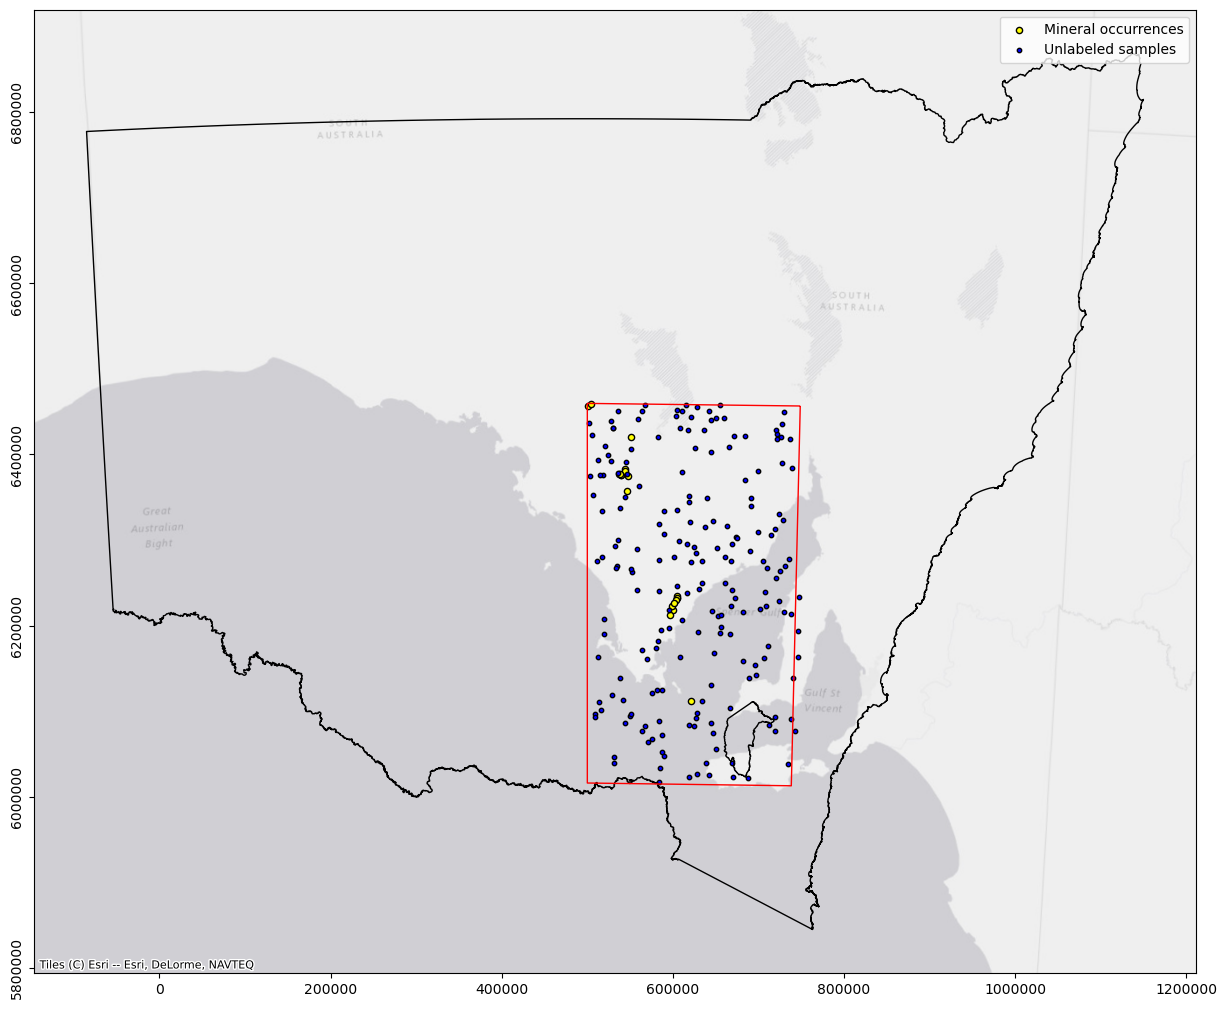

In [18]:
# generate and extract the coordinates of a number of random samples within the desired polygon
def get_non_deposits(polygon, deposit_num):
    #bounds = polygon.bounds
    bounds = lachlan_boundary.bounds
    
    rand_x = np.random.uniform(low=bounds.loc[0]['minx'], high=bounds.loc[0]['maxx'], size=deposit_num*20)
    rand_y = np.random.uniform(low=bounds.loc[0]['miny'], high=bounds.loc[0]['maxy'], size=deposit_num*20)
    #rand_x = np.random.uniform(low=bounds.loc[0]['minx'], high=bounds.loc[0]['maxx'], size=deposit_num*10)
    #rand_y = np.random.uniform(low=bounds.loc[0]['miny'], high=bounds.loc[0]['maxy'], size=deposit_num*10)
    
    non_deposit_x = []
    non_deposit_y = []

    for x, y in zip(rand_x, rand_y):
        if len(non_deposit_x) == deposit_num*10:
        #if len(non_deposit_x) == deposit_num*5:
            break
        p = Point((x, y))
        if p.within(polygon.geometry[0]) or p.within(polygon.geometry[0]):
            non_deposit_x.append(x)
            non_deposit_y.append(y)
    
    return non_deposit_x, non_deposit_y

# export the coordinates of the random samples to a CSV file
coords_file = f'./{commodity}/training_data_non_deposit_coords.csv'

if os.path.isfile(coords_file):
    print('The coordinates of unlabelled samples already exist.')
    non_deposit_coords = pd.read_csv(coords_file, index_col=False)
    non_deposit_x = pd.Series.tolist(non_deposit_coords['X'])
    non_deposit_y = pd.Series.tolist(non_deposit_coords['Y'])
else:
    non_deposit_x, non_deposit_y = get_non_deposits(nsw_boundary, deposit_num)
    non_deposit_coords = pd.DataFrame(non_deposit_x, columns=['X'])
    non_deposit_coords['Y'] = non_deposit_y
    non_deposit_label = [0]*len(non_deposit_x)
    non_deposit_coords['label'] = non_deposit_label
    non_deposit_coords.to_csv(coords_file, index=False)
    print(f'The coordinates of unlabelled samples have been saved to {coords_file}.')

# plot random samples
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(deposit_x, deposit_y, color='yellow',  edgecolors='black', s=20)
ax.scatter(non_deposit_x, non_deposit_y, color='blue', edgecolors='black', s=10)
nsw_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
lachlan_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.legend([
    'Mineral occurrences',
    'Unlabeled samples'
])
plt.show()

### Generating features using the coordinates of unlabelled samples

In [19]:
vector_file = f'./{commodity}/training_data_non_deposit_vector.csv'

if os.path.isfile(vector_file):
    print('The vector dataset (unlabelled samples) already exists.')
    non_deposit_vector_data = pd.read_csv(vector_file, index_col=False)
else:
    non_deposit_vector_data = get_vector_data(non_deposit_x, non_deposit_y)
    non_deposit_vector_data = non_deposit_vector_data[non_deposit_vector_data.columns.intersection(deposit_vector_data.columns)]
    non_deposit_vector_data.to_csv(vector_file, index=False)
    print(f'The vector dataset (unlabelled samples) has been saved to {vector_file}.')

categorical_file = f'./{commodity}/training_data_non_deposit_categorical.csv'

if os.path.isfile(categorical_file):
    print('The categorical dataset (unlabelled samples) already exists.')
    non_deposit_categorical_data = pd.read_csv(categorical_file, index_col=False)
else:
    non_deposit_categorical_data = get_categorical_data(non_deposit_x, non_deposit_y)
    non_deposit_categorical_data = non_deposit_categorical_data[non_deposit_categorical_data.columns.intersection(deposit_categorical_data.columns)]
    non_deposit_categorical_data.to_csv(categorical_file, index=False)
    print(f'The categorical dataset (unlabelled samples) has been saved to {categorical_file}.')

grid_file = f'./{commodity}/training_data_non_deposit_grids.csv'

if os.path.isfile(grid_file):
    print('The grid dataset (unlabelled samples) already exists.')
    non_deposit_grid_data = pd.read_csv(grid_file, index_col=False)
else:
    non_deposit_grid_data = get_grid_data(non_deposit_x, non_deposit_y, grid_filenames)
    non_deposit_grid_data = non_deposit_grid_data[non_deposit_grid_data.columns.intersection(deposit_grid_data.columns)]
    non_deposit_grid_data.to_csv(grid_file, index=False)
    print(f'The grid dataset (unlabelled samples) has been saved to {grid_file}.')

rs_file = f'./{commodity}/training_data_non_deposit_rs.csv'

if os.path.isfile(rs_file):
    print('The remote sensing dataset (unlabelled samples) already exists.')
    non_deposit_rs_data = pd.read_csv(rs_file, index_col=False)
else:
    non_deposit_rs_data = get_grid_data(non_deposit_x, non_deposit_y, rs_filenames)
    non_deposit_rs_data = non_deposit_rs_data[non_deposit_rs_data.columns.intersection(deposit_rs_data.columns)]
    non_deposit_rs_data.to_csv(rs_file, index=False)
    print(f'The remote sensing dataset (unlabelled samples) has been saved to {rs_file}.')

dem_file = f'./{commodity}/training_data_non_deposit_dem.csv'

if os.path.isfile(dem_file):
    print('The dem dataset (unlabelled samples) already exists.')
    non_deposit_dem_data = pd.read_csv(dem_file, index_col=False)
else:
    non_deposit_dem_data = get_gradient_data(non_deposit_x, non_deposit_y, dem_filenames)
    non_deposit_dem_data = non_deposit_dem_data[non_deposit_dem_data.columns.intersection(deposit_dem_data.columns)]
    non_deposit_dem_data.to_csv(dem_file, index=False)
    print(f'The dem dataset (unlabelled samples) has been saved to {dem_file}.')

The vector dataset (unlabelled samples) has been saved to ./Ni-Co laterites/training_data_non_deposit_vector.csv.


  0%|          | 0/33 [00:00<?, ?it/s]

The categorical dataset (unlabelled samples) has been saved to ./Ni-Co laterites/training_data_non_deposit_categorical.csv.


  0%|          | 0/54 [00:00<?, ?it/s]

The grid dataset (unlabelled samples) has been saved to ./Ni-Co laterites/training_data_non_deposit_grids.csv.


  0%|          | 0/14 [00:00<?, ?it/s]

The remote sensing dataset (unlabelled samples) has been saved to ./Ni-Co laterites/training_data_non_deposit_rs.csv.
The dem dataset (unlabelled samples) has been saved to ./Ni-Co laterites/training_data_non_deposit_dem.csv.


In [20]:
# concatenate all the features generated in the previous cell
training_data_file = f'./{commodity}/training_data_non_deposit_nogeochem.csv'

if os.path.isfile(training_data_file):
    print('The training data file (unlabelled samples) already exists.')
    non_deposit_training_data = pd.read_csv(training_data_file, index_col=False)
else:
    #non_deposit_training_data = pd.concat([non_deposit_coords, non_deposit_grid_data, non_deposit_rs_data,
                                           #non_deposit_dem_data], axis=1)
    non_deposit_training_data = pd.concat([non_deposit_coords, non_deposit_grid_data, non_deposit_rs_data,
                                           non_deposit_dem_data, non_deposit_vector_data, non_deposit_categorical_data], axis=1)
    non_deposit_training_data.to_csv(training_data_file, index=False)
    print(f'The training data file (unlabelled samples) has been saved to {training_data_file}.')

# export the features and labels
features_labels_file = f'./{commodity}/features_labels_{commodity}_nogeochem.csv'

# remove missing values
non_deposit_training_data = non_deposit_training_data.dropna()
non_deposit_training_data = non_deposit_training_data[non_deposit_training_data.columns.intersection(deposit_training_data.columns)]

# separate numerical and categorical features
non_deposit_numerical_data = non_deposit_training_data[deposit_numerical_data.columns]
non_deposit_categorical_data = non_deposit_training_data[deposit_categorical_data.columns]
non_deposit_labels = non_deposit_training_data[non_deposit_training_data.columns[2]]

# drop highly correlated features
numerical_data_df = pd.concat([deposit_numerical_data, non_deposit_numerical_data]).reset_index(drop=True)
# create a correlation matrix
corr_matrix = numerical_data_df.corr(method='spearman').abs()
# select the upper triangle of the correlation matrix
corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# find features with the correlation greater than 0.7
corr_drop = [column for column in corr_upper.columns if any(corr_upper[column] > 0.7)]
# drop features
numerical_data_df.drop(corr_drop, axis=1, inplace=True)
numerical_data_columns = numerical_data_df.columns.tolist()

# concatenate the features generated using mineral occurrences and random samples
deposit_training_data_uncorr = pd.concat([deposit_coords, deposit_numerical_data[deposit_numerical_data.columns.intersection(numerical_data_df.columns)],
                                          deposit_categorical_data], axis=1).reset_index(drop=True)

numerical_data = numerical_data_df.to_numpy()
categorical_data = np.vstack((deposit_categorical_data, non_deposit_categorical_data)).astype('str')

scaler = StandardScaler()
scaler.fit(numerical_data)
numerical_features = scaler.transform(numerical_data)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categorical_data)
categorical_features = enc.transform(categorical_data).toarray()

features = np.hstack((numerical_features, categorical_features))
labels = pd.concat([deposit_labels, non_deposit_labels]).reset_index(drop=True)
features_labels = np.hstack((features, np.reshape(labels.to_numpy(), (-1, 1))))
#categorical_data_columns = enc.get_feature_names(deposit_categorical_data.columns).tolist()
categorical_data_columns = enc.get_feature_names_out(deposit_categorical_data.columns).tolist()
features_list = numerical_data_columns + categorical_data_columns

# Filter features list to remove features ending in '_Null'
features_list = [feature for feature in features_list if not feature.endswith('_Null')]

features_list_label = features_list.copy()
features_list_label.append('label')

# Select the relevant columns from features_labels
selected_features_labels = features_labels[:, [features_list.index(col) for col in features_list_label[:-1]]]

# Create the DataFrame with the selected features and labels
features_labels_df = pd.DataFrame(selected_features_labels, columns=features_list_label[:-1])

# Add the 'label' column to the DataFrame
features_labels_df['label'] = labels

# Save the DataFrame to CSV
features_labels_df.to_csv(features_labels_file, index=False)
print(f'The features and labels file has been saved to {features_labels_file}.')

# features_list_label = features_list.copy()
# features_list_label.append('label')
# features_labels = pd.DataFrame(features_labels, columns=features_list_label)
# features_labels.to_csv(features_labels_file, index=False)
# print(f'The features and labels file has been saved to {features_labels_file}.')

The training data file (unlabelled samples) has been saved to ./Ni-Co laterites/training_data_non_deposit_nogeochem.csv.
The features and labels file has been saved to ./Ni-Co laterites/features_labels_Ni-Co laterites_nogeochem.csv.


### Standard Random Forest classification
Please note that prior to running the next cell, you need to generate a synthetic set of positive samples using the SMOTE-GAN notebook.

In [21]:
# generate a confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    '''pretty print for confusion matrixes'''
    columnwidth = max([len(x) for x in labels]) + 4
    empty_cell = ' ' * columnwidth
    print('    ' + empty_cell, end=' ')
    for label in labels:
        print('%{0}s'.format(columnwidth) % 'pred_' + label, end=' ')
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print('    %{0}s'.format(columnwidth) % 'true_' + label1, end=' ')
        for j in range(len(labels)):
            cell = '%{0}.1f'.format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            if cell:
                print(cell, end=' ')
        print()

features_labels_file = f'./{commodity}/smote_gan_{commodity}_nogeochem.csv'
features_labels = pd.read_csv(features_labels_file, index_col=False)
features_labels_pul = features_labels.sample(frac=1).reset_index(drop=True)
features_pul = features_labels_pul[features_labels_pul.columns[:-1]].copy()
labels_pul = features_labels_pul[features_labels_pul.columns[-1]].copy()

# hide 30 percent of the samples labelled one
hidden_size = round(0.3 * (labels_pul==1).sum())

labels_pul_training = labels_pul.copy()
rand_ind = np.random.choice(labels_pul_training[labels_pul_training==1].index, replace=False, size=hidden_size)
labels_pul_training.loc[rand_ind] = 0

# Random Forest model structure
rf = RandomForestClassifier(n_jobs=-1, random_state=1)

print('Parameters currently in use:\n')
pprint(rf.get_params())

# n_estimators: number of trees in the foreset
# max_features: max number of features considered for splitting a node
# max_depth: max number of levels in each decision tree
# min_samples_split: min number of data points placed in a node before the node is split
# min_samples_leaf: min number of data points allowed in a leaf node
# bootstrap: method for sampling data points (with or without replacement)

rf.fit(features_pul, labels_pul_training)

print('')
print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf.predict(features_pul)))

print('')
print('---- {} ----'.format('Standard Random Forest (Hidden Samples)'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
print('Recall: ', recall_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
print('F1 score: ', f1_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        194.0          0.0 
           true_positive         58.0        136.0 
None

Precision:  1.0
Recall:  0.7010309278350515
Accuracy:  0.8505154639175257
F1 score:  0.8242424242424242
ROC AUC score:  0.8505154639175257

---- Standard Random Forest (Hidden Samples) ----
                        pred_negative        pred_positive 
           true_negative          0.0          0.0 
           true_positive         58.0          0.0 
None

P

### Hyperparameter tuning

In [22]:
# number of trees in the Random Forest
n_estimators = [int(x) for x in np.arange(20, 220, 20)]
# number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# maximum number of levels in each tree
max_depth = [int(x) for x in np.arange(10, 110, 10)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]
# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]}


In [23]:
# use the random grid to search for best hyperparameters
# random search of hyperparameters using 10 fold cross validation
# search across 100 different combinations and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                               cv=10, verbose=2, random_state=1, n_jobs=-1)

# fit the random search model
rf_random.fit(features_pul, labels_pul_training)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200]},
                   random_state=1, verbose=2)

In [24]:
# best set of hyperparameters
rf_random.best_params_

{'n_estimators': 120,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [25]:
# run the Random Forest classifier using the best set of hyperparameters
rf_random_best = rf_random.best_estimator_
rf_random_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf_random_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf_random_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf_random_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf_random_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf_random_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf_random_best.predict(features_pul)))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        194.0          0.0 
           true_positive         59.0        135.0 
None

Precision:  1.0
Recall:  0.6958762886597938
Accuracy:  0.8479381443298969
F1 score:  0.8206686930091185
ROC AUC score:  0.8479381443298969


In [26]:
# create the parameter grid based on the results of the random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 5, 10],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [30, 40, 50, 170, 180, 190]
}

# instantiate the grid search model
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# fit the grid search
rf_grid.fit(features_pul, labels_pul_training)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 5, 10],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [30, 40, 50, 170, 180, 190]},
             verbose=2)

In [27]:
# best set of hyperparameters
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 30}

In [28]:
# run the Random Forest classifier using the best set of hyperparameters
rf_grid_best = rf_grid.best_estimator_
rf_grid_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf_grid_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf_grid_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf_grid_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf_grid_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf_grid_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf_grid_best.predict(features_pul)))

print('')
print('---- {} ----'.format('Standard Random Forest (Hidden Samples)'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))
print('Recall: ', recall_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))
print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))
print('F1 score: ', f1_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        194.0          0.0 
           true_positive         22.0        172.0 
None

Precision:  1.0
Recall:  0.8865979381443299
Accuracy:  0.9432989690721649
F1 score:  0.9398907103825136
ROC AUC score:  0.9432989690721649

---- Standard Random Forest (Hidden Samples) ----
                        pred_negative        pred_positive 
           true_negative          0.0          0.0 
           true_positive          8.0         50.0 
None

Precision:  1.0
Recall:  0.8620689655172413
Accuracy:  0.8620689655172413
F1 score:  0.9259259259259259


In [29]:
bc = BaggingPuClassifier(rf_grid_best, max_samples=int(sum(labels_pul_training)), n_jobs=-1, random_state=1)
bc.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Bagging PU'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, bc.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, bc.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, bc.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, bc.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, bc.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, bc.predict(features_pul)))

print('')
print('---- {} ----'.format('Bagging PU (Hidden Samples)'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))
print('Recall: ', recall_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))
print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))
print('F1 score: ', f1_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))

---- Bagging PU ----
                        pred_negative        pred_positive 
           true_negative        193.0          1.0 
           true_positive         17.0        177.0 
None

Precision:  0.9943820224719101
Recall:  0.9123711340206185
Accuracy:  0.9536082474226805
F1 score:  0.9516129032258065
ROC AUC score:  0.9536082474226804

---- Bagging PU (Hidden Samples) ----
                        pred_negative        pred_positive 
           true_negative          0.0          0.0 
           true_positive          5.0         53.0 
None

Precision:  1.0
Recall:  0.9137931034482759
Accuracy:  0.9137931034482759
F1 score:  0.9549549549549551


In [30]:
# number of trees in the Random Forest
n_estimators = [int(x) for x in np.arange(10, 110, 10)]
# number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# maximum number of levels in each tree
max_depth = [int(x) for x in np.arange(10, 60, 10)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]
# create the random grid
bc_random_grid = {'base_estimator__n_estimators': n_estimators,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               'base_estimator__bootstrap': bootstrap}
pprint(bc_random_grid)

{'base_estimator__bootstrap': [True, False],
 'base_estimator__max_depth': [10, 20, 30, 40, 50, None],
 'base_estimator__max_features': ['auto', 'sqrt', 'log2'],
 'base_estimator__min_samples_leaf': [1, 2, 4],
 'base_estimator__min_samples_split': [2, 5, 10],
 'base_estimator__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


In [31]:
bc_random = RandomizedSearchCV(estimator=bc, param_distributions=bc_random_grid, n_iter=100,
                               cv=10, verbose=2, random_state=1, n_jobs=-1)
bc_random.fit(features_pul, labels_pul_training)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10,
                   estimator=BaggingPuClassifier(base_estimator=RandomForestClassifier(max_depth=2,
                                                                                       max_features='auto',
                                                                                       min_samples_leaf=2,
                                                                                       n_estimators=30,
                                                                                       n_jobs=-1,
                                                                                       random_state=1),
                                                 max_samples=136, n_jobs=-1,
                                                 random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'base_estimator__bootstrap': [True,
                                                                      False],
                                        'base_estimator__max_depth': [10, 20,
                                                                      30, 40,
                                                                      50,
                                                                      None],
                                        'base_estimator__max_features': ['auto',
                                                                         'sqrt',
                                                                         'log2'],
                                        'base_estimator__min_samples_leaf': [1,
                                                                             2,
                                                                             4],
                                        'base_estimator__min_samples_split': [2,
                                                                              5,
                                                                              10],
                                        'base_estimator__n_estimators': [10, 20,
                                                                         30, 40,
                                                                         50, 60,
                                                                         70, 80,
                                                                         90,
                                                                         100]},
                   random_state=1, verbose=2)

In [32]:
# best set of hyperparameters
bc_random.best_params_

{'base_estimator__n_estimators': 40,
 'base_estimator__min_samples_split': 5,
 'base_estimator__min_samples_leaf': 4,
 'base_estimator__max_features': 'log2',
 'base_estimator__max_depth': None,
 'base_estimator__bootstrap': True}

In [33]:
# run the Random Forest classifier using the best set of hyperparameters
bc_random_best = bc_random.best_estimator_
bc_random_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Bagging PU'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, bc_random_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, bc_random_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, bc_random_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, bc_random_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, bc_random_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, bc_random_best.predict(features_pul)))

---- Bagging PU ----
                        pred_negative        pred_positive 
           true_negative        194.0          0.0 
           true_positive         15.0        179.0 
None

Precision:  1.0
Recall:  0.9226804123711341
Accuracy:  0.961340206185567
F1 score:  0.9597855227882037
ROC AUC score:  0.961340206185567


In [34]:
# create the parameter grid based on the results of the random search
bc_param_grid = {
    'base_estimator__bootstrap': [True],
    'base_estimator__max_depth': [2, 5, 10],
    'base_estimator__max_features': ['auto'],
    'base_estimator__min_samples_leaf': [1, 2, 4],
    'base_estimator__min_samples_split': [2],
    'base_estimator__n_estimators': [30, 40, 50]
}

# instantiate the grid search model
bc_grid = GridSearchCV(estimator=bc, param_grid=bc_param_grid, cv=10, n_jobs=-1, verbose=2)

# fit the grid search
bc_grid.fit(features_pul, labels_pul_training)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=10,
             estimator=BaggingPuClassifier(base_estimator=RandomForestClassifier(max_depth=2,
                                                                                 max_features='auto',
                                                                                 min_samples_leaf=2,
                                                                                 n_estimators=30,
                                                                                 n_jobs=-1,
                                                                                 random_state=1),
                                           max_samples=136, n_jobs=-1,
                                           random_state=1),
             n_jobs=-1,
             param_grid={'base_estimator__bootstrap': [True],
                         'base_estimator__max_depth': [2, 5, 10],
                         'base_estimator__max_features': ['auto'],
                         'base_estimator__min_samples_leaf': [1, 2, 4],
                         'base_estimator__min_samples_split': [2],
                         'base_estimator__n_estimators': [30, 40, 50]},
             verbose=2)

In [35]:
# best set of hyperparameters
bc_grid.best_params_

{'base_estimator__bootstrap': True,
 'base_estimator__max_depth': 2,
 'base_estimator__max_features': 'auto',
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__n_estimators': 30}

In [36]:
# run the Random Forest classifier using the best set of hyperparameters
bc_grid_best = bc_grid.best_estimator_
bc_grid_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, bc_grid_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, bc_grid_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, bc_grid_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, bc_grid_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, bc_grid_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, bc_grid_best.predict(features_pul)))

print('')
print('---- {} ----'.format('Standard Random Forest (Hidden Samples)'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])))
print('Recall: ', recall_score(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])))
print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])))
print('F1 score: ', f1_score(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        193.0          1.0 
           true_positive         16.0        178.0 
None

Precision:  0.994413407821229
Recall:  0.9175257731958762
Accuracy:  0.9561855670103093
F1 score:  0.9544235924932976
ROC AUC score:  0.9561855670103092

---- Standard Random Forest (Hidden Samples) ----
                        pred_negative        pred_positive 
           true_negative          0.0          0.0 
           true_positive          4.0         54.0 
None

Precision:  1.0
Recall:  0.9310344827586207
Accuracy:  0.9310344827586207
F1 score:  0.9642857142857143


### Feature importance

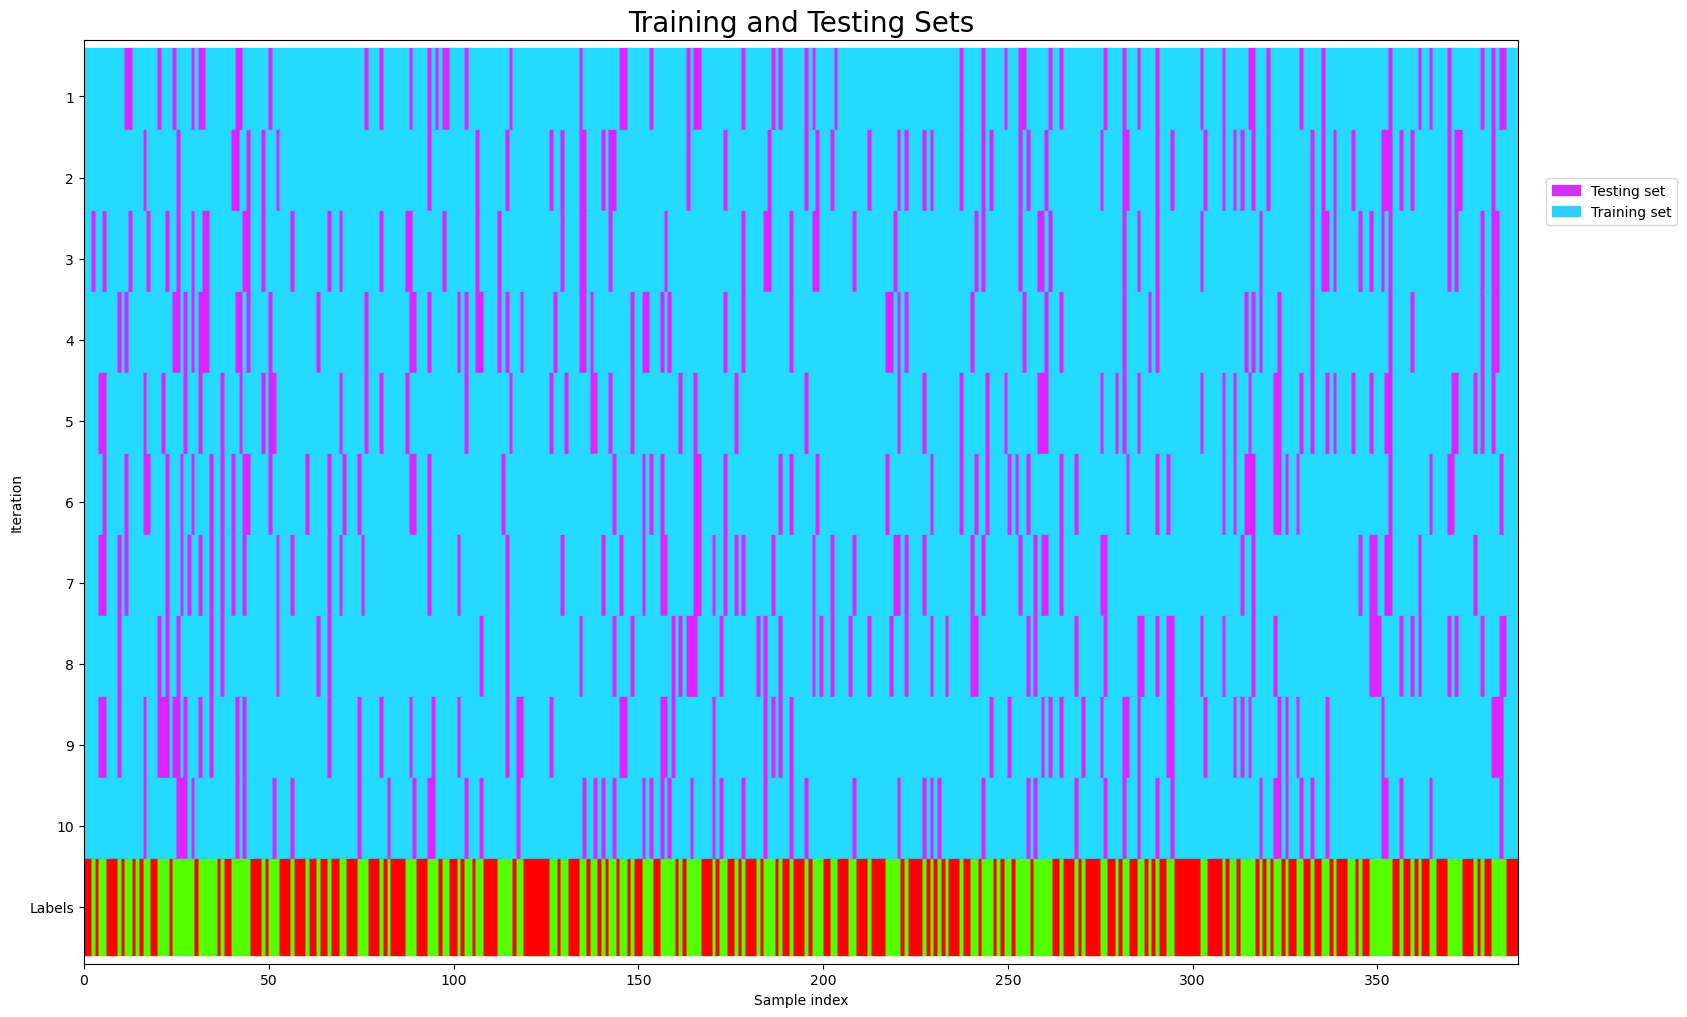

In [37]:
# generate different sets of training samples
iter_num = 10
labels_pul_training_all = np.empty((features_labels_pul.shape[0], iter_num))

fig, ax = plt.subplots()

for i in range(iter_num):
    # hide positive samples
    labels_pul_training = labels_pul.copy()
    labels_pul_training.loc[
        np.random.choice(
            labels_pul_training[labels_pul_training==1].index,
            replace=False,
            size=hidden_size
            )
        ] = 0
    
    labels_pul_training_all[:, i] = labels_pul_training
        
    # fill in indices with the training/testing groups
    indices = labels_pul - labels_pul_training

    # visualise the results
    ax.scatter(range(len(indices)), [i+.5]*len(indices),
                   c=indices, marker='_', lw=70, cmap='cool',
                   vmin=-.2, vmax=1.2)

# plot the data classes and groups at the end
ax.scatter(range(len(features_labels_pul)), [i+1.5]*len(features_labels_pul), c=labels_pul, marker='_', lw=70, cmap='prism')

n_splits = iter_num
yticklabels = list(range(1, n_splits+1)) + ['Labels']
ax.set(yticks=np.arange(n_splits+1)+0.5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel='Iteration',
           ylim=[n_splits+1.2, -.2], xlim=[0, len(features_labels_pul)])
ax.set_title('Training and Testing Sets', fontsize=20)
ax.legend([Patch(color=plt.cm.cool(.8)), Patch(color=plt.cm.cool(.2))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
fig.set_size_inches(18.5, 12)

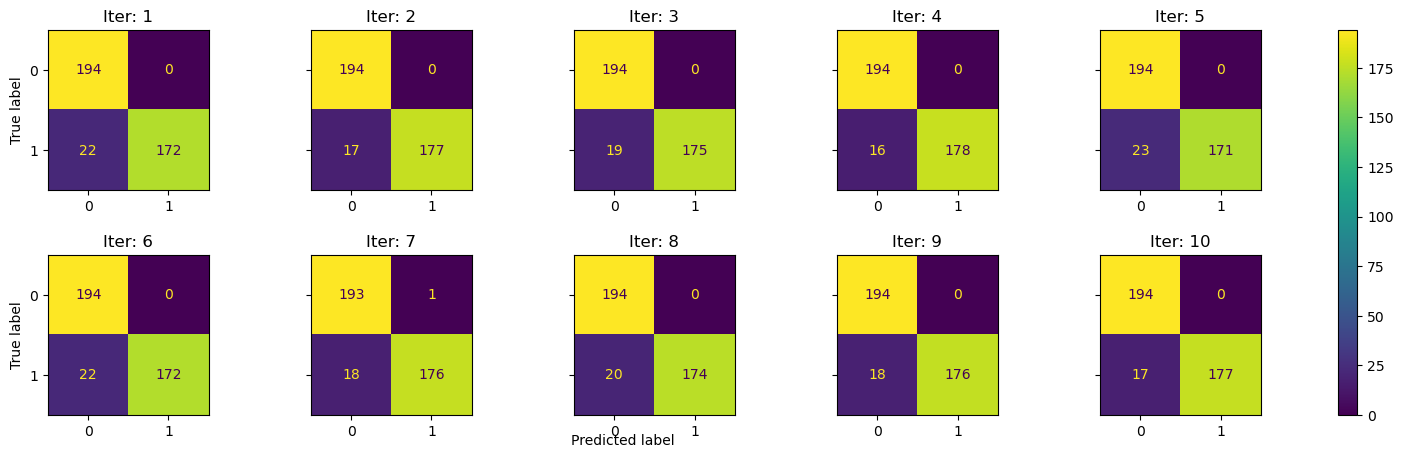

In [38]:
# confusion matrices for different sets of training and testing samples
f, axes = plt.subplots(2, 5, figsize=(20, 5), sharey='row')

j = 0
k = 0

for i in range(iter_num):
    rf_grid_best.fit(features_pul, labels_pul_training_all[:, i])
    pred = rf_grid_best.predict(features_pul)
    
    cf_matrix = confusion_matrix(labels_pul, pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[j, k])
    disp.ax_.set_title('Iter: '+str(i+1))
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0 and i!=5:
        disp.ax_.set_ylabel('')
    
    k += 1
    if i == 4:
        j = 1
        k = 0

f.text(0.4, 0.05, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [39]:
# run the Random Forest classifier for ten times and take the average of feature importance values
importances = np.empty((len(features_list), iter_num))

for i in tqdm(range(iter_num)):
    rf_grid_best.fit(features_pul, labels_pul_training_all[:, i])
    importances[:, i] = rf_grid_best.feature_importances_

importances_mean = importances.mean(axis=1)
importances_var = importances.var(axis=1)

feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(features_list, importances_mean)]
feature_importances = sorted(feature_importances, key=lambda x:x[1], reverse=True)
[print('Feature: {:60} Importance: {}'.format(*pair)) for pair in feature_importances]

with open(f'feature_importance_{commodity}.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(feature_importances)

  0%|          | 0/10 [00:00<?, ?it/s]

Feature: Quartz_Index_mean                                            Importance: 0.11952
Feature: MetamorphicFacies_Tabberabberan_Greenschist facies           Importance: 0.11421
Feature: Magmap2019_tmr_rtp_enh_Bzz_PGravTHD_mean                     Importance: 0.09454
Feature: Quartz_Index_dissimilarity                                   Importance: 0.07607
Feature: Gravmap2019_dtgir_IA_std                                     Importance: 0.05321
Feature: Magmap2019_tmi_rtp_enh_Bzz_Phase_dissimilarity               Importance: 0.04784
Feature: MetamorphicFacies_Tabberabberan_Subgreenschist facies        Importance: 0.04467
Feature: Ferrous_Iron_in_MgOH_mean                                    Importance: 0.04013
Feature: Kaolin_Group_Index_correlation                               Importance: 0.03857
Feature: Magmap2019_tmi_rtp_upcon_UC0m500mRes_correlation             Importance: 0.03359
Feature: Gravmap2019_freeair_IA_correlation                           Importance: 0.03099
Feature: M

In [40]:
print(len(feature_importances))

82


Number of features for 90% importance: 16


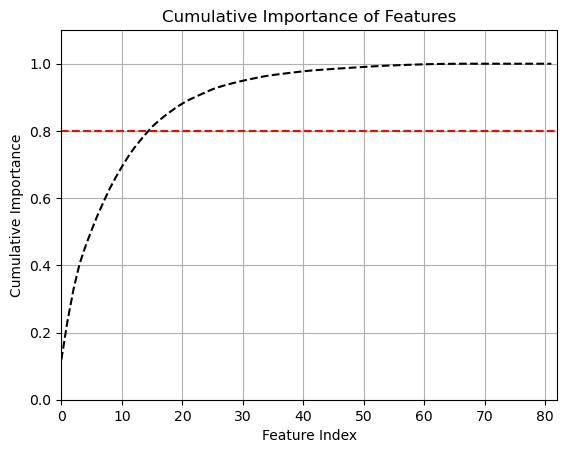

In [41]:
# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)
# make a linear graph
x_values = list(range(len(feature_importances)))
plt.plot(x_values, cumulative_importances, 'k--')
# draw a line at 80% of the importance retained
plt.hlines(y=0.8, xmin=0, xmax=len(sorted_importances), color='r', linestyles='dashed')
# # format x ticks and labels
# plt.xticks(x_values, sorted_features, rotation='vertical')
# axis labels and title
plt.xlabel('Feature Index')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importance of Features')
plt.grid()
plt.ylim(0, 1.1)
plt.xlim(0, len(feature_importances))

important_features_num = np.where(cumulative_importances > 0.80)[0][0] + 1
print('Number of features for 90% importance:', important_features_num)

In [42]:
# extract the names of the most important features
important_features_list = [feature[0] for feature in feature_importances[0:important_features_num]]
# create training and testing sets with only the important features
features_pul_important = features_pul[important_features_list]

# run the Random Forest classifier using the best set of hyperparameters and the most important features
rf_grid_best.fit(features_pul_important, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf_grid_best.predict(features_pul_important)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf_grid_best.predict(features_pul_important)))
print('Recall: ', recall_score(labels_pul, rf_grid_best.predict(features_pul_important)))
print('Accuracy: ', accuracy_score(labels_pul, rf_grid_best.predict(features_pul_important)))
print('F1 score: ', f1_score(labels_pul, rf_grid_best.predict(features_pul_important)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf_grid_best.predict(features_pul_important)))

print('')
print('---- {} ----'.format('Standard Random Forest (Hidden Samples)'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul_important.loc[rand_ind])), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul_important.loc[rand_ind])))
print('Recall: ', recall_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul_important.loc[rand_ind])))
print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul_important.loc[rand_ind])))
print('F1 score: ', f1_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul_important.loc[rand_ind])))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        194.0          0.0 
           true_positive         16.0        178.0 
None

Precision:  1.0
Recall:  0.9175257731958762
Accuracy:  0.9587628865979382
F1 score:  0.956989247311828
ROC AUC score:  0.9587628865979381

---- Standard Random Forest (Hidden Samples) ----
                        pred_negative        pred_positive 
           true_negative          0.0          0.0 
           true_positive          3.0         55.0 
None

Precision:  1.0
Recall:  0.9482758620689655
Accuracy:  0.9482758620689655
F1 score:  0.9734513274336283


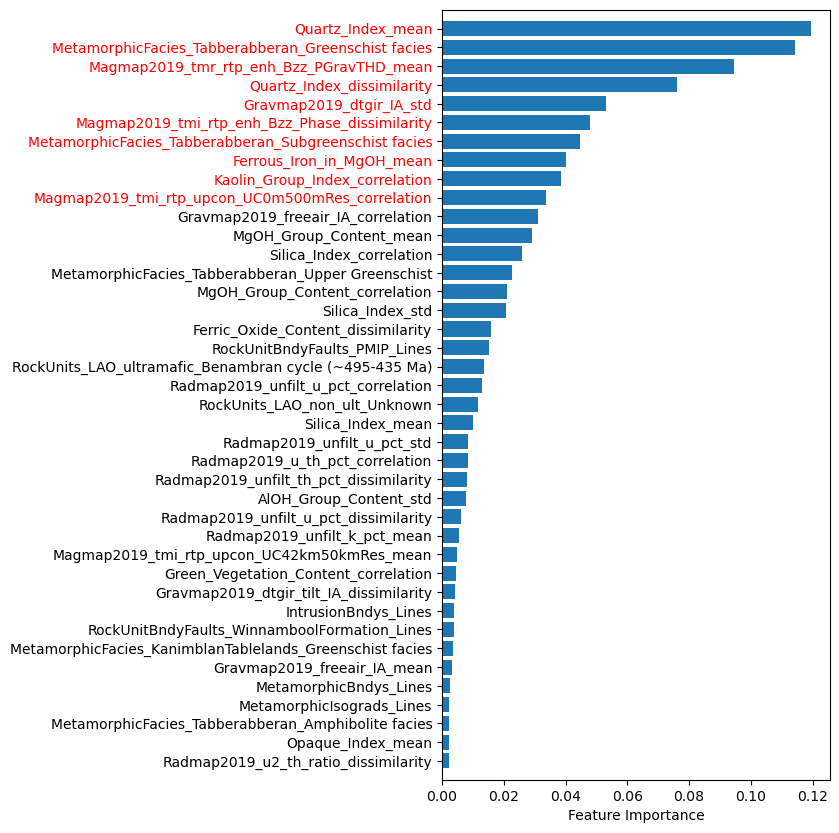

In [43]:
# print significant features above some threshold
feature_importances.sort(key=lambda x:x[1])
feature_importances_plot = feature_importances[-40:]

fig, ax = plt.subplots(figsize=(5, 10))

ft_imps = [x[1] for x in feature_importances_plot]
y_pos = np.arange(len(feature_importances_plot))
ax.barh(y_pos, ft_imps, align='center')
ax.set_ylim(-1, len(ft_imps))
ax.set_yticks(range(len(ft_imps)))
ax.set_yticklabels([x[0] for x in feature_importances_plot])

# highlight top 10 features
for i in range(len(ft_imps)-10, len(ft_imps)):
    ax.get_yticklabels()[i].set_color('red')

ax.set_xlabel('Feature Importance')

plt.show()